# Institute-only Earnings Model
Predict MD_EARN_WNE_P10 using institution features, compare classifiers for VALUE_LABEL, and rank colleges with user weights.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from IPython.display import display



## Data paths
Adjust if your CSVs live elsewhere.


In [2]:

CANDIDATE_INSTITUTION = [
    "../data/institute_level_processed_most_recent.csv",
]

def pick_path(candidates):
    for p in candidates:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"None of these paths exist: {candidates}")

DATA_PATH = pick_path(CANDIDATE_INSTITUTION)
print("Using DATA_PATH:", DATA_PATH)



Using DATA_PATH: ../data/institute_level_processed_most_recent.csv


In [3]:

CANDIDATE_COURSE = [
    "../data/course_level_processed_combined.csv",
]

COURSE_PATH = pick_path(CANDIDATE_COURSE)
print("Using COURSE_PATH:", COURSE_PATH)


Using COURSE_PATH: ../data/course_level_processed_combined.csv


## Load data, define target/label, and feature sets
- Target: `MD_EARN_WNE_P10`
- VALUE_LABEL: affordable + high quality
- Separate feature sets to avoid leakage in classification


In [4]:
inst_df = pd.read_csv(DATA_PATH)
print("Institution data shape:", inst_df.shape)
print("Institution columns:", inst_df.columns.tolist())

# Clean UNITID to merge with course aggregates
inst_df["UNITID"] = pd.to_numeric(inst_df["UNITID"], errors="coerce")
inst_df = inst_df.dropna(subset=["UNITID"])
inst_df["UNITID"] = inst_df["UNITID"].astype(int)

# Load and aggregate course-level data
course_df = pd.read_csv(COURSE_PATH, low_memory=False)
print("Course data shape:", course_df.shape)
course_df["UNITID"] = pd.to_numeric(course_df["UNITID"], errors="coerce")
before = len(course_df)
course_df = course_df.dropna(subset=["UNITID"])
after = len(course_df)
print(f"Dropped {before - after} invalid UNITID rows from course_df.")
course_df["UNITID"] = course_df["UNITID"].astype(int)

agg_cols = ["DEBT_ALL_STGP_ANY_MDN", "DEBT_ALL_PP_ANY_MDN"]
for col in agg_cols:
    if col in course_df.columns:
        course_df[col] = pd.to_numeric(course_df[col], errors="coerce")

base_cols_for_course = ["UNITID", "CIPCODE", "CREDLEV"]
course_subset_cols = base_cols_for_course + [c for c in agg_cols if c in course_df.columns]
course_df_subset = course_df[course_subset_cols].copy()

agg_dict = {
    "CIPCODE": "nunique",  # distinct programs
    "CREDLEV": "nunique",  # distinct credential levels
}
if "DEBT_ALL_STGP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_STGP_ANY_MDN"] = ["mean", "min", "max"]
if "DEBT_ALL_PP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_PP_ANY_MDN"] = ["mean", "min", "max"]

course_agg = course_df_subset.groupby("UNITID").agg(agg_dict)
course_agg.columns = ["_".join([str(c) for c in col if c]) if isinstance(col, tuple) else col for col in course_agg.columns]
course_agg = course_agg.rename(columns={
    "CIPCODE_nunique": "ENG_PROG_COUNT",
    "CREDLEV_nunique": "ENG_CRED_LEVELS",
})
print("Aggregated course-level shape:", course_agg.shape)

# Merge
df = inst_df.merge(course_agg, on="UNITID", how="left")
print("Merged df shape:", df.shape)

TARGET = "MD_EARN_WNE_P10"
if TARGET not in df.columns:
    raise ValueError(f"Target {TARGET} not found in data")

cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
df["VALUE_LABEL"] = ((df["COSTT4_A"] <= cost_med) & (df["QUALITY_SCORE"] >= quality_med)).astype(int)
print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

base_features_reg = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "COSTT4_A", "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]
course_features = [
    "ENG_PROG_COUNT", "ENG_CRED_LEVELS",
    "DEBT_ALL_STGP_ANY_MDN_mean", "DEBT_ALL_STGP_ANY_MDN_min", "DEBT_ALL_STGP_ANY_MDN_max",
    "DEBT_ALL_PP_ANY_MDN_mean", "DEBT_ALL_PP_ANY_MDN_min", "DEBT_ALL_PP_ANY_MDN_max",
]
# drop QUALITY_SCORE ingredients from classification to avoid leakage into VALUE_LABEL
value_leak_cols = {"GRAD_RATE", "RET_FT4", "QUALITY_SCORE", "MD_EARN_WNE_P10"}
base_features_cls = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]
feature_cols_reg = [c for c in (base_features_reg + course_features) if c in df.columns]
feature_cols_cls = [c for c in (base_features_cls + course_features) if c in df.columns and c not in value_leak_cols]
print("Regression features:", feature_cols_reg)
print("Classification features (leakage-guarded):", feature_cols_cls)

cls_df = df.dropna(subset=["VALUE_LABEL"])
X_cls = cls_df[feature_cols_cls]
y_cls = cls_df["VALUE_LABEL"]
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
print("Classification train size:", Xc_train.shape[0])
print("Classification test size:", Xc_test.shape[0])

reg_df = df.dropna(subset=[TARGET])
X_reg = reg_df[feature_cols_reg]
y_reg = reg_df[TARGET]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print("Regression train size:", Xr_train.shape[0])
print("Regression test size:", Xr_test.shape[0])


Institution data shape: (5650, 33)
Institution columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LATITUDE', 'LONGITUDE', 'PCIP14', 'PCIP15', 'ENG_TOTAL', 'ENG_RATIO', 'PCIP11', 'STEM_TOTAL', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'MD_EARN_WNE_P10', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
Course data shape: (121798, 71)
Dropped 2401 invalid UNITID rows from course_df.
Aggregated course-level shape: (2875, 8)
Merged df shape: (5650, 41)
VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64
Regression features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'COSTT4_A', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FO

## Stable normalization stats (for ranking)


In [5]:

norm_stats = {}
for col in ["COSTT4_A", "ENG_RATIO", "QUALITY_SCORE", "ADM_RATE", TARGET]:
    if col in df.columns:
        col_min = df[col].min()
        col_max = df[col].max()
        if col_max == col_min:
            col_max = col_min + 1e-9
        norm_stats[col] = (col_min, col_max)

def minmax_with_stats(series, stats):
    mn, mx = stats
    denom = mx - mn
    return (series - mn) / (denom if denom > 0 else 1e-9)



## Classification models (VALUE_LABEL) — CV ROC AUC


Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 0.1, 'clf__class_weight': 'balanced'}
Best CV ROC AUC: 0.700

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       780
           1       0.43      0.68      0.52       350

    accuracy                           0.62      1130
   macro avg       0.62      0.64      0.60      1130
weighted avg       0.69      0.62      0.63      1130

Test ROC AUC: 0.6899267399267399
Confusion matrix:
[[461 319]
 [112 238]]


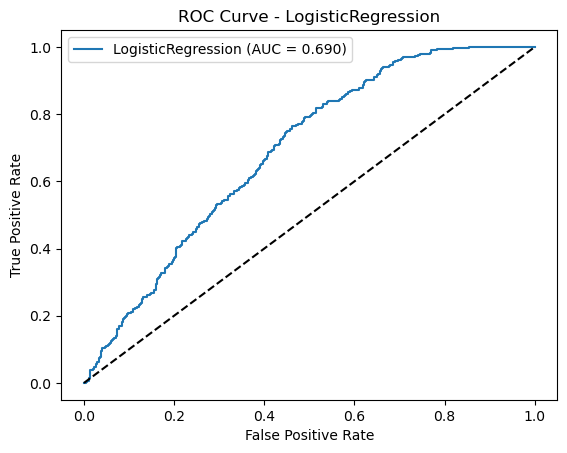

Running RandomForest
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for RandomForest:
{'clf__class_weight': None, 'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
Best CV ROC AUC: 0.841

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       780
           1       0.67      0.49      0.57       350

    accuracy                           0.77      1130
   macro avg       0.73      0.69      0.70      1130
weighted avg       0.76      0.77      0.76      1130

Test ROC AUC: 0.8246849816849817
Confusion matrix:
[[697  83]
 [179 171]]


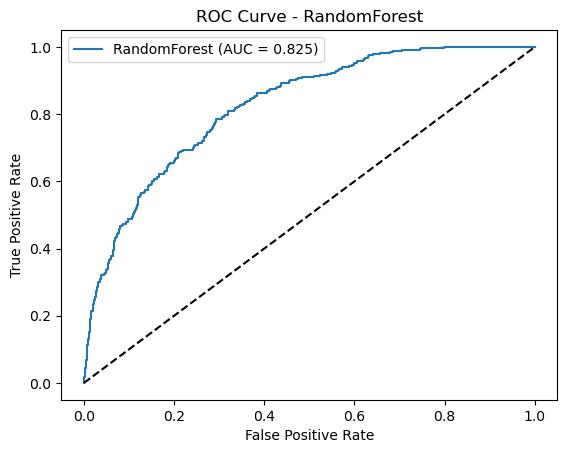

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Best CV ROC AUC: 0.832

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       780
           1       0.67      0.50      0.57       350

    accuracy                           0.77      1130
   macro avg       0.73      0.69      0.71      1130
weighted avg       0.76      0.77      0.76      1130

Test ROC AUC: 0.8189945054945056
Confusion matrix:
[[693  87]
 [176 174]]


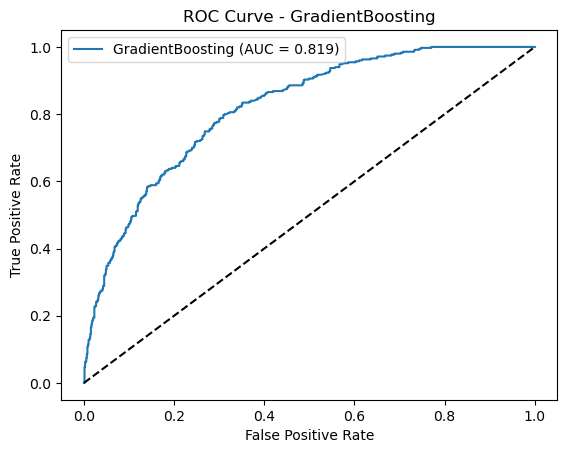

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 25, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.780

Test classification report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       780
           1       0.65      0.38      0.48       350

    accuracy                           0.75      1130
   macro avg       0.71      0.65      0.66      1130
weighted avg       0.73      0.75      0.72      1130

Test ROC AUC: 0.7816373626373627
Confusion matrix:
[[708  72]
 [216 134]]


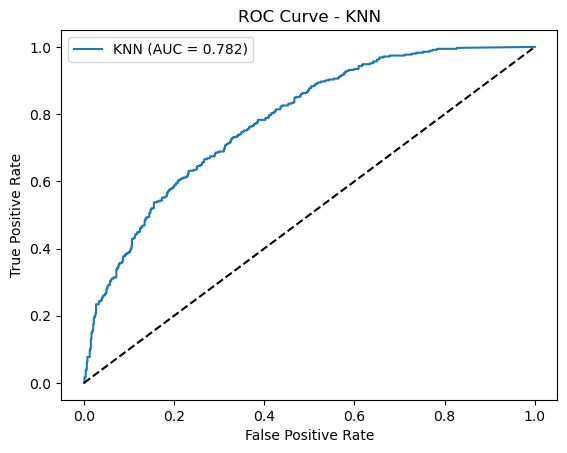

Running SVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for SVC:
{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.790

Test classification report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       780
           1       0.58      0.65      0.62       350

    accuracy                           0.75      1130
   macro avg       0.71      0.72      0.71      1130
weighted avg       0.76      0.75      0.75      1130

Test ROC AUC: 0.7902014652014652
Confusion matrix:
[[616 164]
 [121 229]]


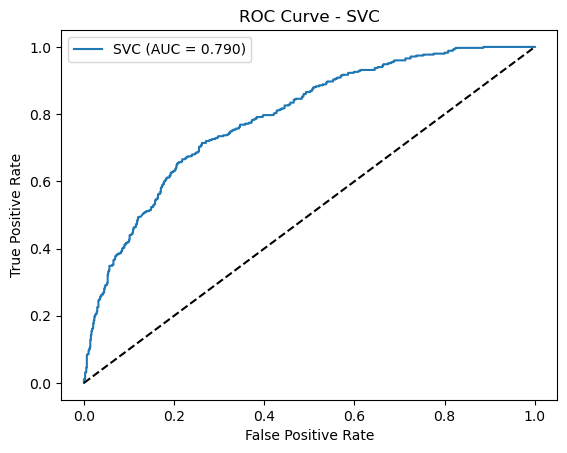

Selected value classifier: RandomForest (CV ROC AUC = 0.841, test ROC AUC = 0.825)


In [6]:

classifiers = {}

log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
log_reg_grid = {"clf__C": [0.01, 0.1, 1, 10], "clf__class_weight": [None, "balanced"]}
classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_grid)

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])
rf_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": [None, "balanced"],
}
classifiers["RandomForest"] = (rf_pipe, rf_grid)

gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5],
}
classifiers["GradientBoosting"] = (gb_pipe, gb_grid)

knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
knn_grid = {"clf__n_neighbors": [5, 15, 25], "clf__weights": ["uniform", "distance"]}
classifiers["KNN"] = (knn_pipe, knn_grid)

svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])
svc_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"],
}
classifiers["SVC"] = (svc_pipe, svc_grid)

best_classifiers = {}
cv_best_scores = {}
test_metrics = {}
cv_results_dict = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)
    grid.fit(Xc_train, yc_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_
    best_model = grid.best_estimator_
    best_classifiers[name] = best_model
    cv_results_dict[name] = pd.DataFrame(grid.cv_results_)

    y_pred = best_model.predict(Xc_test)
    y_proba = best_model.predict_proba(Xc_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(yc_test, y_pred))
    auc = roc_auc_score(yc_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(yc_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    fpr, tpr, _ = roc_curve(yc_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

best_cls_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_cls_name]
print(
    f"Selected value classifier: {best_cls_name} "
    f"(CV ROC AUC = {cv_best_scores[best_cls_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_cls_name]['roc_auc']:.3f})"
)



### Classification results (no-leak)
- AUC dropped after removing GRAD_RATE, RET_FT4, QUALITY_SCORE, and earnings: RF 0.846>0.821; GB 0.843>0.823; SVC 0.824>0.795; KNN 0.814>0.789; LogReg 0.724>0.689.
- Positive-class recall mostly fell: RF 0.57>0.49; GB 0.55>0.51; KNN 0.48>0.43; SVC 0.72>0.68. LogReg recall rose to ~0.67 with class_weight balanced, but precision/accuracy dropped.
- Confusion matrices show more misses on positives: e.g., RF FN 150>180 (TP 200>170); SVC FN 98>111 (TP 252>239); GB FN 158>172.
- Takeaway: scores now reflect realistic signal without leakage. RF remains top AUC, GB close. For higher recall, adjust thresholds or imbalance handling.
(For the leaky baseline metrics, see the original notebook ML_institute_only_earnings_slider.ipynb; nothing there was changed.)
 - Overall classification model here works better than the regression

## Regression models (MD_EARN_WNE_P10) — CV R²


In [7]:

regressors = {}

rf_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestRegressor(random_state=42))
])
rf_reg_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}
regressors["RandomForestRegressor"] = (rf_reg, rf_reg_grid)

gb_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingRegressor(random_state=42))
])
gb_reg_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5],
}
regressors["GradientBoostingRegressor"] = (gb_reg, gb_reg_grid)

en_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", ElasticNet(max_iter=5000))
])
en_reg_grid = {
    "clf__alpha": [0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.1, 0.5, 0.9],
}
regressors["ElasticNet"] = (en_reg, en_reg_grid)

svr_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVR())
])
svr_reg_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__epsilon": [0.01, 0.1, 0.2],
}
regressors["SVR"] = (svr_reg, svr_reg_grid)

best_regressors = {}
reg_cv_best_scores = {}
reg_test_metrics = {}

for name, (pipe, param_grid) in regressors.items():
    print("="*80)
    print(f"Running {name}")
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
    grid.fit(Xr_train, yr_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores[name] = grid.best_score_
    best_model = grid.best_estimator_
    best_regressors[name] = best_model

    preds = best_model.predict(Xr_test)
    r2 = r2_score(yr_test, preds)
    rmse = mean_squared_error(yr_test, preds, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics[name] = {"r2": r2, "rmse": rmse}

    plt.figure()
    plt.scatter(yr_test, preds, alpha=0.4)
    plt.xlabel("True MD_EARN_WNE_P10")
    plt.ylabel("Predicted MD_EARN_WNE_P10")
    plt.title(f"{name} - Prediction vs True")
    plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], "r--")
    plt.show()

best_reg_name = max(reg_cv_best_scores, key=reg_cv_best_scores.get)
earnings_model = best_regressors[best_reg_name]
print(
    f"Selected main earnings model: {best_reg_name} "
    f"(CV R² = {reg_cv_best_scores[best_reg_name]:.3f}, "
    f"test R² = {reg_test_metrics[best_reg_name]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics[best_reg_name]['rmse']:.3f})"
)



Running RandomForestRegressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

# regression model is taking time when the course level features gets added so needed to kill it. The downstream blocks can be explored once the regression model runs.

# So we focus on the "ML_institute_only_earnings_slider.ipynb" and "ML_institute_only_earnings_slider_no_leak.ipynb" to see the slider use cases - In both of them the regression model, there is no leak - no overfitting

## Ranking helper
Combines predicted earnings, value probability, cost, engineering, research, admission, sector, and location with user-defined weights.


In [8]:

def admission_bucket(adm):
    if pd.isna(adm):
        return "Unknown"
    if adm >= 0.70:
        return "High admit (>=70%)"
    if adm >= 0.30:
        return "Medium admit (30-70%)"
    return "Low admit (<30%)"

def rank_colleges(
    df_raw,
    feature_cols_reg,
    feature_cols_cls,
    earnings_model,
    value_model,
    user_weights,
    norm_stats,
    preferred_state=None
):
    df_scored = df_raw.copy()

    X_reg_all = df_scored[feature_cols_reg]
    X_cls_all = df_scored[feature_cols_cls]

    df_scored["earn_pred"] = earnings_model.predict(X_reg_all)
    if value_model is not None:
        df_scored["p_value_model"] = value_model.predict_proba(X_cls_all)[:, 1]
    else:
        df_scored["p_value_model"] = 0.5

    def score_with_stats(col_name, out_col, invert=False):
        if col_name in df_scored.columns and col_name in norm_stats:
            vals = minmax_with_stats(df_scored[col_name].astype(float), norm_stats[col_name])
            df_scored[out_col] = 1 - vals if invert else vals
        else:
            df_scored[out_col] = 0.5

    score_with_stats("COSTT4_A", "cost_score", invert=True)
    score_with_stats("ENG_RATIO", "eng_score")
    score_with_stats("QUALITY_SCORE", "research_score")
    score_with_stats("ADM_RATE", "adm_score")
    if TARGET in norm_stats:
        df_scored["earn_score"] = minmax_with_stats(df_scored["earn_pred"], norm_stats[TARGET])
    else:
        df_scored["earn_score"] = 0.5

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if preferred_state is not None and "STABBR" in df_scored.columns:
        df_scored["location_score"] = (df_scored["STABBR"] == preferred_state).astype(float)
    else:
        df_scored["location_score"] = 0.5

    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_research = user_weights.get("research", 0)
    w_earn    = user_weights.get("earnings", 0)
    w_loc     = user_weights.get("location", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)
    w_adm     = user_weights.get("admission", 0)

    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_research + w_earn + w_loc + w_public + w_private + w_adm
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_research * df_scored["research_score"] +
        w_earn  * df_scored["earn_score"] +
        w_loc   * df_scored["location_score"] +
        w_adm   * (1 - df_scored["adm_score"]) +
        sector_component
    ) / total_w

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    if "ADM_RATE" in df_scored.columns:
        ranked["ADM_BUCKET"] = df_scored["ADM_RATE"].apply(admission_bucket)

    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "earn_pred", "COSTT4_A", "ENG_RATIO", "p_value_model", "USER_SCORE", "ADM_BUCKET"
    ]
    cols_to_show = [c for c in cols_to_show if c in ranked.columns]
    return ranked[cols_to_show]



## Example ranking
Set your preferred state (or None) and adjust weights.


In [ ]:

# example_weights = {
#     "value_model": 2,
#     "cost": 4,
#     "engineering": 3,
#     "research": 3,
#     "earnings": 5,
#     "location": 2,
#     "prefer_public": 2,
#     "prefer_private": 0,
#     "admission": 1,
# }

# preferred_state_example = "FL"  # or None

# ranked = rank_colleges(
#     df_raw=df,
#     feature_cols_reg=feature_cols_reg,
#     feature_cols_cls=feature_cols_cls,
#     earnings_model=earnings_model,
#     value_model=value_model,
#     user_weights=example_weights,
#     norm_stats=norm_stats,
#     preferred_state=preferred_state_example,
# )

# ranked.head(20)



,INSTNM,CITY,STABBR,earn_pred,COSTT4_A,ENG_RATIO,p_value_model,USER_SCORE,ADM_BUCKET
579,University of Florida,Gainesville,FL,75050.722900,21719.0,0.138414,0.401012,0.625639,Low admit (<30%)
578,Florida State University,Tallahassee,FL,63788.005143,23683.0,0.038504,0.848286,0.622634,Low admit (<30%)
572,Florida International University,Miami,FL,60013.692261,20556.0,0.073993,0.891119,0.612898,Medium admit (30-70%)
2081,United States Merchant Marine Academy,Kings Point,NY,53499.743960,9547.0,0.520500,0.735665,0.608093,Medium admit (30-70%)
5015,University of Florida-Online,Gainesville,FL,57575.194496,17036.0,0.000000,0.850859,0.607401,Medium admit (30-70%)
640,University of South Florida,Tampa,FL,59981.717501,22301.0,0.056706,0.824393,0.607336,Medium admit (30-70%)
552,University of Central Florida,Orlando,FL,61176.331466,22819.0,0.083300,0.739401,0.605598,Medium admit (30-70%)
658,University of West Florida,Pensacola,FL,57259.344811,18504.0,0.056011,0.852274,0.598995,Medium admit (30-70%)
614,University of North Florida,Jacksonville,FL,56558.199699,20229.0,0.060906,0.906095,0.596107,Medium admit (30-70%)
697,Georgia Institute of Technology-Main Campus,Atlanta,GA,91370.832385,27797.0,0.464600,0.189359,0.594205,Low admit (<30%)


## Interactive sliders for weights
Drag sliders to adjust weights and choose state; reruns ranking and shows top 10.


In [ ]:

# import ipywidgets as widgets
# from IPython.display import display, clear_output

# states = sorted(df["STABBR"].dropna().unique())
# state_dropdown = widgets.Dropdown(options=[None]+states, description='State')

# slider_cfg = {
#     "value_model": widgets.IntSlider(value=2, min=0, max=5, description='Value'),
#     "cost": widgets.IntSlider(value=4, min=0, max=5, description='Cost'),
#     "engineering": widgets.IntSlider(value=3, min=0, max=5, description='Eng'),
#     "research": widgets.IntSlider(value=3, min=0, max=5, description='Research'),
#     "earnings": widgets.IntSlider(value=5, min=0, max=5, description='Earnings'),
#     "location": widgets.IntSlider(value=2, min=0, max=5, description='Location'),
#     "prefer_public": widgets.IntSlider(value=2, min=0, max=5, description='Public'),
#     "prefer_private": widgets.IntSlider(value=0, min=0, max=5, description='Private'),
#     "admission": widgets.IntSlider(value=1, min=0, max=5, description='Admission'),
# }

# go_button = widgets.Button(description='Rank', button_style='primary')
# out = widgets.Output()

# @go_button.on_click
# def on_click(btn):
#     weights = {k: w.value for k, w in slider_cfg.items()}
#     preferred_state = state_dropdown.value
#     ranked = rank_colleges(
#         df_raw=df,
#         feature_cols_reg=feature_cols_reg,
#         feature_cols_cls=feature_cols_cls,
#         earnings_model=earnings_model,
#         value_model=value_model,
#         user_weights=weights,
#         norm_stats=norm_stats,
#         preferred_state=preferred_state,
#     )
#     with out:
#         clear_output()
#         display(ranked.head(10))

# controls = widgets.VBox(list(slider_cfg.values()) + [state_dropdown, go_button])
# display(widgets.HBox([controls, out]))



# Let's explore different slider scenarios: Compare three configurations by adjusting only the “Location” and “Private” weights while keeping State fixed to “FL.”

# case 1: 
location preference : 1/5 (FL in these examples)

private preference : 0/5

others : not changed accross the three cases...

# TODO

conclusion case 1: state being least priority we get colleges from states other than Florida too in the top rankings..

# case 2: 
location preference : 5/5 (FL in these examples)

private preference : 0/5

others : not changed accross the three cases...

# TODO

conclusion case 2: state being highest priority we get colleges mostly from Florida..

# case 3: 
location preference : 5/5 (FL in these examples)

private preference : 3/5

public preference : 1/5

others : not changed accross the three cases...

# TODO

conclusion case 3: more private universities before we get one public university UF!
UF being on the list also adds to the point that it is not purely "filtering + sorting"